Esse código é um script em Python que gera consultas SQL baseado em tabelas e relações do TOTVS RM.


In [1]:
# Importações

import os.path
from datetime import datetime
from itertools import islice

# Possivelmente tem que instalar
# pip install networkx numpy pandas
import networkx as nx  # Para manipulação e visualização de grafos
import numpy as np  # Para operações numéricas e manipulação de arrays
import pandas as pd  # Para manipulação de dados tabulares

In [2]:
# Definição de cores ANSI para formatação de saída no console


class cores:
    END = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    STRIKETHROUGH = "\033[9m"
    BLACK_BG = "\033[40m"
    BLACK_FG = "\033[30m"
    RED_BG = "\033[41m"
    RED_FG = "\033[91m"
    GREEN_BG = "\033[42m"
    GREEN_FG = "\033[92m"
    YELLOW_FG = "\033[93m"
    YELLOW_BG = "\033[43m"
    BLUE_FG = "\033[94m"
    BLUE_BG = "\033[44m"
    PURPLE_FG = "\033[95m"
    PURPLE_BG = "\033[45m"
    WHITE_FG = "\033[97m"
    WHITE_BG = "\033[47m"

As planilhas `GDIC.XLSX` e `GLINKSREL.XLSX` devem ser geradas no seu sistema atual com as seguintes SQL

```sql
SELECT TABELA,
       COLUNA,
       DESCRICAO
FROM   GDIC (NOLOCK) /* Lista tabelas do sistema, seus campos e suas descrições */
```

```sql
SELECT MASTERTABLE,
       CHILDTABLE,
       MASTERFIELD,
       CHILDFIELD
FROM   GLINKSREL (NOLOCK) /* Lista relacionamentos entre tabelas */
```


In [3]:
# Leitura de Tabelas e Relacionamentos


def le_arquivo_excel(caminho):
    # Procura pelo arquvio excel
    if not os.path.isfile(caminho):
        raise Exception("Arquivo não existe.")

    caminho_pickle = os.path.splitext(caminho)[0] + ".pkl"

    # Procura pelo arquivo pickle (excel ja processado pelo pandas)
    if os.path.isfile(caminho_pickle):
        return pd.read_pickle(caminho_pickle)
    else:
        # Se não encontrou
        # Processa o excel com o pandas
        df = pd.read_excel(io=caminho).dropna().astype(str)

        # Converte os valores das seguintes colunas em maiusculas
        for coluna in [
            "TABELA",
            "COLUNA",
            "MASTERTABLE",
            "CHILDTABLE",
            "MASTERFIELD",
            "CHILDFIELD",
        ]:
            try:
                df[coluna] = df[coluna].str.upper()
            except KeyError:
                pass

        # Substitui ';' por ',' e apaga caracteres invalidos nas seguintes colunas
        for coluna in ["MASTERFIELD", "CHILDFIELD"]:
            try:
                df[coluna] = df[coluna].str.replace(";", ",")
                df[coluna] = df[coluna].str.replace(
                    r"[^0-9A-Z,_]", "", regex=True
                )
            except KeyError:
                pass

        # Salva como arquivo pickle
        df.to_pickle(caminho_pickle)
        return df


tabelas = le_arquivo_excel(
    os.path.join(os.getcwd(), "dados", "GDIC_TOTVS_RM_2306_113.XLSX")
)
relacoes = le_arquivo_excel(
    os.path.join(os.getcwd(), "dados", "GLINKSREL_TOTVS_RM_2306_113.XLSX")
)

#### Organização de Relacionamentos

No contexto do TOTVS RM, a tabela `GLINKSREL` desempenha um papel crucial ao armazenar informações sobre relacionamentos entre tabelas, considerando tanto a relação de ida quanto a de volta. Para ilustrar, suponha que a tabela `SALUNO` se relacione com a tabela `PPESSOA` por meio das chaves `CODPESSOA` e `CODIGO`, respectivamente. Na tabela `GLINKSREL`, essas relações seriam representadas da seguinte maneira:

| `MASTERTABLE` | `CHILDTABLE` | `MASTERFIELD` | `CHILDFIELD` |
| :-----------: | :----------: | :-----------: | :----------: |
|   `PPESSOA`   |   `SALUNO`   |   `CODIGO`    | `CODPESSOA`  |
|   `SALUNO`    |  `PPESSOA`   |  `CODPESSOA`  |   `CODIGO`   |

A função `unifica_relacoes()` é que organiza essas tabelas de relacionamento em ordem alfabética e elimina duplicatas.

|    `A`    |   `B`    |       `LIGACOES`        |
| :-------: | :------: | :---------------------: |
| `PPESSOA` | `SALUNO` | (`CODIGO`, `CODPESSOA`) |


In [4]:
def unifica_relacoes():
    # Procura pelo arquivo pickle (ja processado pelo pandas)
    caminho_pickle = os.path.join(os.getcwd(), "dados", "relacoesUnicas.pkl")
    if os.path.isfile(caminho_pickle):
        return pd.read_pickle(caminho_pickle)

    # Ordena a linha e cria um dataframe
    relacoes_unicas = pd.DataFrame(np.sort(relacoes.iloc[:, :2]))
    # Remove duplicados
    relacoes_unicas = relacoes_unicas.drop_duplicates(ignore_index=True)

    # Cria nova coluna com um conjunto vazio
    relacoes_unicas["LIGACOES"] = [set() for _ in range(len(relacoes_unicas))]

    for [a, b, s] in relacoes_unicas.values:
        # Filtra as relacoes com infos de chaves extrangeiras
        A = relacoes.loc[
            (relacoes["MASTERTABLE"] == a) & (relacoes["CHILDTABLE"] == b),
            ["MASTERFIELD", "CHILDFIELD"],
        ]
        B = relacoes.loc[
            (relacoes["MASTERTABLE"] == b) & (relacoes["CHILDTABLE"] == a),
            ["CHILDFIELD", "MASTERFIELD"],
        ]

        # Salva as relacoes encontradas no conjunto
        for [a_chaves, b_chaves] in A.values:
            s.add((a_chaves, b_chaves))
        for [a_chaves, b_chaves] in B.values:
            s.add((a_chaves, b_chaves))

    # Salva num arquivo pickle para nao ter que recalcular
    relacoes_unicas.to_pickle(caminho_pickle)

    return relacoes_unicas


relacoes = unifica_relacoes()

In [5]:
print(f"{tabelas.iloc[:,0].drop_duplicates().shape[0]} tabelas definidas.")
print(f"{tabelas.shape[0]} colunas de tabelas definidas.")
print(f"{relacoes['LIGACOES'].map(len).sum()}", end="")
print(" relações definidas entre tabelas.")

7908 tabelas definidas.
125681 colunas de tabelas definidas.
16233 relações definidas entre tabelas.


In [6]:
def gera_grafo_relacoes(relacionamentos, abandona_disconexos=True):
    # Cria grafo a partir de uma tabela de relações
    grafo = nx.from_pandas_edgelist(relacionamentos, source=0, target=1)

    if not nx.is_connected(grafo):
        print("O grafo gerado tem subgrafos disconexos do principal.")
        if abandona_disconexos:
            grafo = grafo.subgraph(
                sorted(nx.connected_components(grafo), key=len)[-1]
            )
            print("Subgrafos disconexos foram abandonados.")
        else:
            s = f"Subgrafos disconexos {cores.BOLD}não{cores.END} foram"
            s += " abandonados."
            print(s)

    return grafo


grafo_relacoes = gera_grafo_relacoes(relacoes)
# grafo_relacoes = gera_grafo_relacoes(relacoes, abandona_disconexos=False)

O grafo gerado tem subgrafos disconexos do principal.
Subgrafos disconexos foram abandonados.


In [7]:
# Lista tabelas desejadas no select

tabelas_desejadas = [
    # "DTIPOBAIRRO"
    # "DTIPORUA",
    # "DTRBMUNICIPIOPRD",
    # "EPROFISS",
    # "FBOLETO",
    "FCFO",
    # "FCONTA",
    # "FCONVENIO",
    # "FCXA",
    # "FLAN",
    # "FLANBOLETO",
    # "FLANRATCCU",
    # "FTDO",
    # "GBANCO",
    # "GCCUSTO",
    # "GCOLIGADA",
    # "GFILIAL",
    # "GIMAGEM",
    # "GJOBX",
    # "GJOBXEXECUCAO"
    # "GMUNICIPIO",
    # "GPERFIL",
    # "GUSRPERFIL",
    # "GUSUARIO",
    # "NUSUARIOLOCALIDADE",
    # "PCODESTCIVIL",
    # "PCODNACAO",
    "PPESSOA",
    "SALUNO",
    # "SBOLSA",
    # "SBOLSAALUNO",
    # "SCONCEITO",
    # "SCONTRATO",
    # "SCURSO",
    # "SDISCGRADE",
    # "SDISCIPLINA",
    # "SETAPAS",
    # "SFILIAL",
    # "SFREQUENCIA",
    # "SGRUPOCONCEITO",
    # "SHABILITACAO",
    # "SHABILITACAOALUNO",
    # "SHABILITACAOFILIAL",
    # "SHORARIO",
    # "SHORARIOPROFESSOR",
    # "SHORARIOTURMA",
    # "SINSTITUICAO",
    # "SJUSTIFICATIVAFALTA",
    # "SLAN",
    # "SLOGPLETIVO",
    # "SMATRICPL",
    # "SMATRICULA",
    # "SMODETAPAPLETIVO",
    # "SMODPROVAPLETIVO",
    # "SMOTIVOALTMAT",
    # "SNOTAETAPA",
    # "SNOTAETAPACOMENTARIO",
    # "SNOTAS",
    # "SNOTASCOMENTARIO",
    # "SPARCELA",
    # "SPARCPLANO",
    # "SPLANOAULA",
    # "SPLANOPGTO",
    # "SPLETIVO",
    # "SPROFESSOR",
    # "SPROFESSORCOMPL",
    # "SPROFESSORTURMA",
    # "SPROVAS",
    # "SSERVICO",
    # "SSTATUS",
    # "STIPOMATRICULA",
    # "STURMA",
    # "STURMADISC",
    # "STURMADISCCOMPL",
    # "STURNO",
    # "SUSUARIOFILIAL",
    # "TMOV",
    # "TNFEMUNICIPAL",
    # "TNFEMUNICIPALHIST",
    # "TPRDCODFISCAL",
    # "TPRDFISCAL",
    # "TPRODUTO",
    # "TTBORCAMENTO",
    # "TTRBPRD",
    # "VFILIACAO",
]

if len(tabelas_desejadas) == 0:
    raise ValueError("A lista tabelas_desejadas não pode estar vazia.")

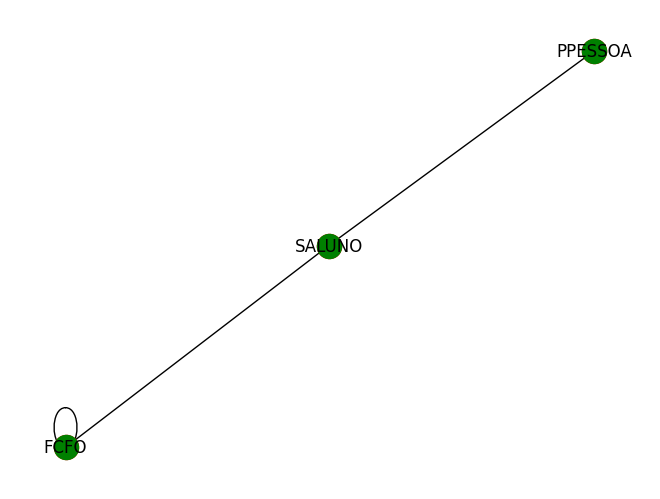

In [8]:
def exibe_conexao_tabelas(
    tabelas_selecionadas=None,
    tabelas_opcionais=None,
    layout=None,
    remove_auto_referencias=False,
):
    if tabelas_selecionadas is None:
        tabelas_selecionadas = tabelas_desejadas.copy()

    if tabelas_opcionais is not None:
        tabelas_selecionadas.extend(tabelas_opcionais)

    grafo_selecionado = nx.Graph(grafo_relacoes.subgraph(tabelas_selecionadas))

    if remove_auto_referencias:
        grafo_selecionado.remove_edges_from(
            nx.selfloop_edges(grafo_selecionado)
        )

    if nx.is_empty(grafo_selecionado):
        if len(tabelas_desejadas) == 0:
            raise ValueError("A lista tabelas_desejadas não pode estar vazia.")
        raise ValueError("Não foi possível encontrar as tabelas_desejadas.")

    elementos_conectados = list(
        sorted(nx.connected_components(grafo_selecionado), key=len)[-1]
    )

    layouts = {
        "elastico": nx.spring_layout,
        "circular": nx.circular_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "aleatorio": nx.random_layout,
        "planar": nx.planar_layout,  # Pode dar erro se o grafo nao for planar
        "espiral": nx.spiral_layout,
    }
    pos = layouts.get(layout, nx.kamada_kawai_layout)(grafo_selecionado)

    # Pinta de vermelho todas as tabelas selecionadas
    nx.draw(grafo_selecionado, pos=pos, with_labels=True, node_color="r")

    # Pinta de verde os elementos conectados
    nx.draw_networkx_nodes(
        grafo_selecionado,
        pos=pos,
        nodelist=elementos_conectados,
        node_color="g",
    )

    if len(list(grafo_selecionado)) != len(elementos_conectados):
        mensagem_alerta = f"{cores.YELLOW_FG}Alerta: Existem tabelas d"
        mensagem_alerta += f"isconexas marcadas em {cores.RED_BG}verme"
        mensagem_alerta += f"lho{cores.END}{cores.YELLOW_FG} que serã"
        mensagem_alerta += f"o ignoradas!{cores.END}\nVocê pode inclui"
        mensagem_alerta += f"r tabelas na lista de desejadas para compl"
        mensagem_alerta += f"etar a ligação"
        print(mensagem_alerta)

    if tabelas_opcionais is not None:
        # Pinta de amarelo os elementos para fazer novas conexões
        nx.draw_networkx_nodes(
            grafo_selecionado,
            pos=pos,
            nodelist=tabelas_opcionais,
            node_color="y",
        )
        mensagem_alerta = f"\nAs tabelas marcadas em {cores.YELLOW_BG}"
        mensagem_alerta += f"{cores.BLACK_FG}amarelo{cores.END} não e"
        mensagem_alerta += f"stão atualmente na seleção e serão ignorad"
        mensagem_alerta += f"as!\nVocê pode inclui-las na lista de dese"
        mensagem_alerta += f"jadas para completar a ligação"
        print(mensagem_alerta)


exibe_conexao_tabelas()

In [9]:
def conexoes_possiveis_faltantes(tabelas_selecionadas=tabelas_desejadas):
    def k_menores_caminhos(grafo, origem, destino, k=3):
        try:
            return list(
                islice(nx.shortest_simple_paths(grafo, origem, destino), k)
            )
        except nx.NetworkXNoPath:
            print(f"Não existe caminho possível entre {destino} e {origem}.")
            return []

    grafo_selecionado = grafo_relacoes.subgraph(tabelas_selecionadas)

    elementos_conectados = grafo_selecionado.subgraph(
        list(sorted(nx.connected_components(grafo_selecionado), key=len)[-1])
    )

    elementos_desconectados = set(grafo_selecionado).difference(
        set(elementos_conectados)
    )

    if not elementos_desconectados:
        print("Todos os nós estão conectados!")
        return

    mensagem_alerta = f"{cores.YELLOW_FG}Nem todas as seguintes ligaçõe"
    mensagem_alerta += f"s podem fazer sentido para o seu contexto.\nUs"
    mensagem_alerta += f"e extrema cautela!{cores.END}\n\nLicações poss"
    mensagem_alerta += f"iveis para atingir as tabelas disconexas:"
    print(mensagem_alerta)

    elementos_conexao = set()
    for ec in elementos_conectados:
        for ed in elementos_desconectados:
            for caminho in k_menores_caminhos(grafo_relacoes, ec, ed):
                print(" - " + " <-> ".join(caminho))
                for tabela in caminho[1:-1]:
                    elementos_conexao.add(tabela)

    exibe_conexao_tabelas(
        tabelas_opcionais=elementos_conexao, remove_auto_referencias=True
    )


conexoes_possiveis_faltantes()

Todos os nós estão conectados!


In [10]:
def descricao(tabela, coluna="#"):
    """Retorna a descrição de uma tabela ou coluna."""
    try:
        return tabelas.loc[
            (tabelas["TABELA"] == tabela) & (tabelas["COLUNA"] == coluna),
            ["DESCRICAO"],
        ].iloc[0, 0]
    except IndexError:
        return "Descrição não encontrada"

SFREQUENCIA (Freqüência do Aluno) tem relacionamento com as seguintes tabelas:
 - SHORARIOTURMA: Horários da Turma Disciplina
 - SJUSTIFICATIVAFALTA: Justificativas de faltas
 - SMATRICULA: Matrícula do Aluno em cada Disciplina


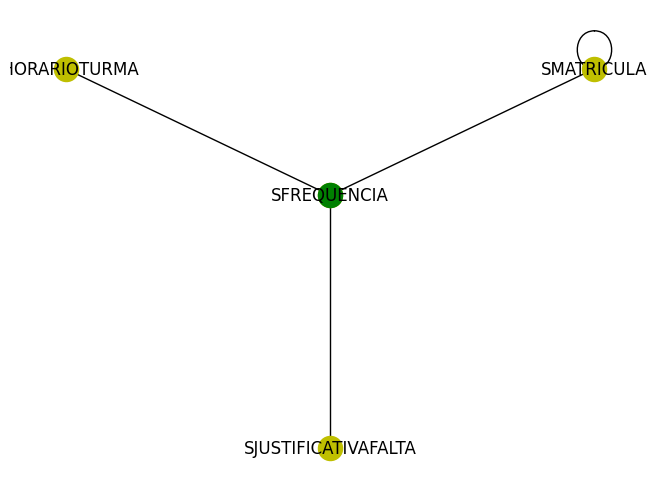

In [11]:
def exibe_vizinhos_tabela(central, layout=None, grafo=grafo_relacoes):
    if central not in grafo:
        raise ValueError(f"A tabela {central} não foi encontrada.")

    grafo_ego = nx.ego_graph(grafo, central)

    print(f"{central} ({descricao(central)})", end="")
    print(" tem relacionamento com as seguintes tabelas:")

    vizinhos = np.sort(grafo_ego)
    if central not in nx.nodes_with_selfloops(grafo_ego):
        vizinhos = np.delete(vizinhos, vizinhos == central)
    [print(f" - {v}: {descricao(v)}") for v in vizinhos]

    grau = dict(grafo_ego.degree()).get(central)
    if grau > 60:
        raise ResourceWarning(f"Não é possivel visualizar {grau} elementos.")

    layouts = {
        "elastico": nx.spring_layout,
        "circular": nx.circular_layout,
        "kamada_kawai": nx.kamada_kawai_layout,
        "aleatorio": nx.random_layout,
        "planar": nx.planar_layout,  # Pode dar erro se o grafo nao for planar
        "espiral": nx.spiral_layout,
    }
    pos = layouts.get(layout, nx.kamada_kawai_layout)(grafo_ego)

    nx.draw(grafo_ego, pos=pos, with_labels=True, node_color="y")
    nx.draw_networkx_nodes(
        grafo_ego, pos=pos, nodelist=[central], node_color="g"
    )


exibe_vizinhos_tabela("SFREQUENCIA")

In [12]:
def ordena_por_dependencia(tabelas_selecionadas=tabelas_desejadas, raiz=None):
    grafo_selecionado = grafo_relacoes.subgraph(tabelas_selecionadas)

    # Se não foi especificada uma raiz, define como a tabela de maior grau
    if raiz is None:
        sem_selfloops = grafo_selecionado.copy()
        sem_selfloops.remove_edges_from(nx.selfloop_edges(sem_selfloops))
        graus = dict(sem_selfloops.degree())
        raiz = max(graus, key=graus.get)

    if raiz not in grafo_selecionado:
        raise ValueError(
            f"A tabela {raiz} não foi encontrada na lista de seleção."
        )

    # Obtém os sucessores de cada nó no grafo a partir da raiz usando DFS
    dependencias = nx.dfs_successors(grafo_selecionado, source=raiz)

    ordenado = []
    fila = [[raiz]]

    # Percorre os nós do grafo em largura (BFS)
    while fila:
        sucessores = fila.pop(0)
        for elemento in sucessores:
            ordenado.append(elemento)
            if elemento in dependencias:
                # Se o nó tem sucessores, adiciona esses sucessores à fila
                fila.append(dependencias[elemento])

    max_len = len(str(len(ordenado)))
    for i, tabela in enumerate(ordenado):
        print(f"{str(i).rjust(max_len, '0')}: {tabela}")

    return ordenado


# tabelas_desejadas = ordena_por_dependencia(raiz=tabelas_desejadas[0])
tabelas_desejadas = ordena_por_dependencia()

0: SALUNO
1: FCFO
2: PPESSOA


In [13]:
def compoe_select(tabelas_selecionadas=tabelas_desejadas, descricoes=True):
    def escreve_colunas_tabela(tabela, ultima_tabela=False):
        # Obtém as informações sobre as colunas da tabela no DataFrame `tabelas`
        t = tabelas[tabelas["TABELA"] == tabela]

        s = ""
        if descricoes:
            s = f"\t/* {descricao(tabela)} */\n"

        # Remove colunas específicas que não são relevantes para a seleção
        descartar = [
            "IDFT",  # Índice full-text, inútil
            "#",  # Descrição da tabela
            "RECCREATEDBY",  # Registro criado por
            "RECCREATEDON",  # Registro criado em
            "RECMODIFIEDBY",  # Última modificação do registro por
            "RECMODIFIEDON",  # Última modificação do registro em
        ]
        t = t.loc[~t["COLUNA"].isin(descartar)].sort_values(by=["COLUNA"])

        # Determina o maior comprimento das str das colunas para alinhamento
        max_len = len(f"\t{t.iloc[0,0]}.{max(t['COLUNA'], key=len)}")

        ultima_coluna = len(t) - 1
        for i, (_, linha) in enumerate(t.iterrows()):
            # Gera a cláusula de seleção para cada coluna da tabela
            s += f"\t{linha['TABELA']}.{linha['COLUNA']}".ljust(max_len, " ")
            s += f" AS {linha['TABELA']}_{linha['COLUNA']}"
            s += "" if ultima_tabela and i == ultima_coluna else ","
            s += f" /* {linha['DESCRICAO']} */\n" if descricoes else "\n"
        return s

    # Combina as cláusulas de seleção para cada tabela em uma string completa
    s = "SELECT\n"
    s += "\n".join(map(escreve_colunas_tabela, tabelas_selecionadas[:-1]))
    s += "\n" + escreve_colunas_tabela(tabelas_selecionadas[-1], True)
    return s


clausula_select = compoe_select()
print(clausula_select)

SELECT
	/* Aluno */
	SALUNO.ANOINGRESSO    AS SALUNO_ANOINGRESSO, /* Ano de Ingresso */
	SALUNO.ANOTACOES      AS SALUNO_ANOTACOES, /* Anortações */
	SALUNO.CODAREA        AS SALUNO_CODAREA, /* Código da Área */
	SALUNO.CODCARREIRA    AS SALUNO_CODCARREIRA, /* Código da Carreira */
	SALUNO.CODCFO         AS SALUNO_CODCFO, /* Código do Cliente/Fornecedor */
	SALUNO.CODCOLCFO      AS SALUNO_CODCOLCFO, /* Código da Coligada do Cliente/Fornecedor */
	SALUNO.CODCOLIGADA    AS SALUNO_CODCOLIGADA, /* Código da Coligada */
	SALUNO.CODCURSOHIST   AS SALUNO_CODCURSOHIST, /* Código do Curso do Histórico */
	SALUNO.CODIDIOMA      AS SALUNO_CODIDIOMA, /* Código do Idioma */
	SALUNO.CODINSTDESTINO AS SALUNO_CODINSTDESTINO, /* Código da Instituição de Destino */
	SALUNO.CODINSTORIGEM  AS SALUNO_CODINSTORIGEM, /* Código da Instituição de Origem */
	SALUNO.CODPARENTCFO   AS SALUNO_CODPARENTCFO, /* Código do Parentesco do Resp. Fin. */
	SALUNO.CODPARENTRACA  AS SALUNO_CODPARENTRACA, /* Código do Parente

In [14]:
def compoe_join(
    tabelas_selecionadas=tabelas_desejadas, tipo="LEFT", descricoes=True
):
    def escreve_correspondencia_chaves(tabela_origem, tabela_destino):
        try:
            # Obtém as ligações entre as tabelas a partir do DataFrame `relacoes`
            ligacoes = relacoes.loc[
                (relacoes[0] == min(tabela_origem, tabela_destino))
                & (relacoes[1] == max(tabela_origem, tabela_destino)),
                ["LIGACOES"],
            ].iloc[0, 0]
        except IndexError:
            # Se não houver ligações definidas, retorna uma string vazia
            return ""

        s = f"\t\t/* Relações de chaves entre {tabela_origem} e {tabela_destino} */\n"
        if len(ligacoes) > 1:
            s += f"\t\t/* Existem {len(ligacoes)} relações entre as tab"
            s += f"elas {tabela_origem} e {tabela_destino} */\n\t\t/* "
            s += f"Provavelmente você deve escolher apenas uma */\n"
        for i, (chaves_origem, chaves_destino) in enumerate(ligacoes):
            # Se existe mais de uma ligação possível entre as tabelas
            # selecionadas, numera elas
            if len(ligacoes) > 1:
                s += f"\t\t/* Alternativa {i + 1} */\n"

            # Garante que as chaves estejam na ordem correta, já que elas foram
            # ordenadas por ordem alfabetica pela função `unifica_relacoes`
            if min(tabela_origem, tabela_destino) != tabela_origem:
                [chaves_origem, chaves_destino] = [
                    chaves_destino,
                    chaves_origem,
                ]

            chaves_origem = chaves_origem.split(",")
            chaves_destino = chaves_destino.split(",")
            primeiro = True
            for chave_origem, chave_destino in zip(
                chaves_origem, chaves_destino
            ):
                s += f"\t\t{' ON ' if primeiro else 'AND '}"
                s += f"{tabela_origem}.{chave_origem} = "
                s += f"{tabela_destino}.{chave_destino}"
                if descricoes:
                    s += f" /* {descricao(tabela_origem, chave_origem)} "
                    s += f"- {descricao(tabela_destino, chave_destino)} */"
                s += "\n"
                primeiro = False

            if len(chaves_origem) != len(chaves_destino):
                s += "\t\t/* Não há correspondentes para as chaves "
                s += f"estrangeiras abaixo; por favor, avalie */\n"
                for i in range(len(chaves_destino), len(chaves_origem)):
                    s += (
                        f"\t\t/* AND {tabela_origem}.{chaves_origem[i]} = ?? */"
                    )
                    if descricoes:
                        s += f" /* {descricao(tabela_origem, chave_origem)} */"
                    s += "\n"
                for i in range(len(chaves_origem), len(chaves_destino)):
                    s += f"\t\t/* AND {tabela_destino}.{chaves_destino[i]} = ?? */"
                    if descricoes:
                        s += (
                            f" /* {descricao(tabela_destino, chave_destino)} */"
                        )
                    s += "\n"

        if len(ligacoes) > 1:
            s += "\t\t/* Fim alternativas */\n"

        return s

    visitadas = [tabelas_selecionadas[0]]

    # Inicializa a string de saída com a cláusula FROM da primeira tabela
    s = f"FROM {tabelas_selecionadas[0]} (NOLOCK)"
    s += (
        f" /* {descricao(tabelas_selecionadas[0])} */\n" if descricoes else "\n"
    )

    for tabela in tabelas_selecionadas[1:]:
        # Adiciona a cláusula JOIN para cada tabela subsequente
        visitadas.append(tabela)
        s += f"\t{tipo} JOIN {tabela} (NOLOCK)"
        s += f" /* {descricao(tabela)} */\n" if descricoes else "\n"

        for visitada in visitadas:
            # Adiciona as condições de correspondência entre as tabelas
            s += escreve_correspondencia_chaves(visitada, tabela)

    return s


clausula_join = compoe_join()
print(clausula_join)

FROM SALUNO (NOLOCK) /* Aluno */
	LEFT JOIN FCFO (NOLOCK) /* Clientes/Fornecedores */
		/* Relações de chaves entre SALUNO e FCFO */
		 ON SALUNO.CODCOLCFO = FCFO.CODCOLIGADA /* Código da Coligada do Cliente/Fornecedor - Coligada */
		AND SALUNO.CODCFO = FCFO.CODCFO /* Código do Cliente/Fornecedor - Código do Cliente/Fornecedor */
		/* Relações de chaves entre FCFO e FCFO */
		/* Existem 2 relações entre as tabelas FCFO e FCFO */
		/* Provavelmente você deve escolher apenas uma */
		/* Alternativa 1 */
		 ON FCFO.CODCOLIGADA = FCFO.CODCFOCOLINTEGRACAO /* Coligada - Coligada do Fornecedor do Cliente */
		AND FCFO.CODCFO = FCFO.CODCFOINTEGRACAO /* Código do Cliente/Fornecedor - Código do Fornecedor do Cliente */
		/* Alternativa 2 */
		 ON FCFO.CODCFOCOLINTEGRACAO = FCFO.CODCOLIGADA /* Coligada do Fornecedor do Cliente - Coligada */
		AND FCFO.CODCFOINTEGRACAO = FCFO.CODCFO /* Código do Fornecedor do Cliente - Código do Cliente/Fornecedor */
		/* Fim alternativas */
	LEFT JOIN PPESSOA (N

In [15]:
def salva_arquivo_sql():
    # Obtém a data e hora atual no formato AAAAMMDDHHMMSS
    agora = datetime.now().strftime("%Y%m%d%H%M%S")

    nome_arquivo = tabelas_desejadas[0] + "-" + agora + ".sql"

    # Define o caminho para a pasta onde os arquivos serão salvos
    caminho = os.path.join(os.getcwd(), "consultas_geradas")

    # Verifica se a pasta existe; se não existir, a cria
    if not os.path.exists(caminho):
        os.makedirs(caminho)
        print(f"Pasta '{caminho}' criada com sucesso.")

    caminho = os.path.join(caminho, nome_arquivo)

    arquivo = open(caminho, "a")
    arquivo.write(clausula_select + clausula_join)
    arquivo.close()

    print(f"Arquivo '{caminho}' criado com sucesso.")


salva_arquivo_sql()

Pasta '/mnt/c/Users/vitor/Documents/TOTVS-RM-SQL/consultas_geradas' criada com sucesso.
Arquivo '/mnt/c/Users/vitor/Documents/TOTVS-RM-SQL/consultas_geradas/SALUNO-20240109120129.sql' criado com sucesso.
